https://github.com/lcabrp/llm-viz-freecodecamp

## Step 1: Load a Local Model and Tokenizer
This step downloads DistilBERT (a small, free LLM) and prepares it to run locally.

In a file called app.py, paste the following code.

Note: The first time you run it via python app.py, Hugging Face will automatically download the model (~250 MB). You only do this once.

In [2]:
from transformers import AutoTokenizer, AutoModel
import torch

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_hidden_states=True)

d:\lcabr\Documents\Projects\llm-viz-freecodecamp\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading weights: 100%|██████████| 100/100 [00:00<00:00, 814.48it/s, Materializing param=transformer.layer.5.sa_layer_norm.weight]   
DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_layer_norm.bias   | UNEXPECTED |  | 
vocab_transform.weight  | UNEXPECTED |  | 
vocab_transform.bias    | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 
vocab_layer_norm.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


### This code loads a small open-source language model so we can work with it on our own computer.

- First, it imports the Transformers library and PyTorch, which provide the tools to download and run the model. 
- Then it picks the model name (distilbert-base-uncased) and uses AutoTokenizer to turn text into tokens the model understands, while AutoModel downloads the pre-trained model itself and prepares it to return the hidden layer outputs we’ll visualize.

## Step 2: Extract Hidden States
This feeds in text and grabs the “hidden activations” (the neuron outputs inside the model).

In the same app.py, add this function below the step 1 code.

In [3]:
def get_hidden_states(text):
    inputs = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    hidden = outputs.hidden_states[-1][0] # Last hidden layer
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    return tokens, hidden

tokens, hidden = get_hidden_states("I love pizza!")
print(tokens)
print(hidden.shape)

['[CLS]', 'i', 'love', 'pizza', '!', '[SEP]']
torch.Size([6, 768])


Now we can call get_hidden_states("I love pizza!") and it will return tokens like ["i", "love", "pizza", "!"] and a big tensor of numbers.

You can use python app.py to run the code.

### Step 3: Visualize Sentiment Activations
This step plots how neuron values differ for happy vs. sad sentences. We’ll compare activations for positive and negative movie reviews.

In the same app.py, add this function below the step 2 code.

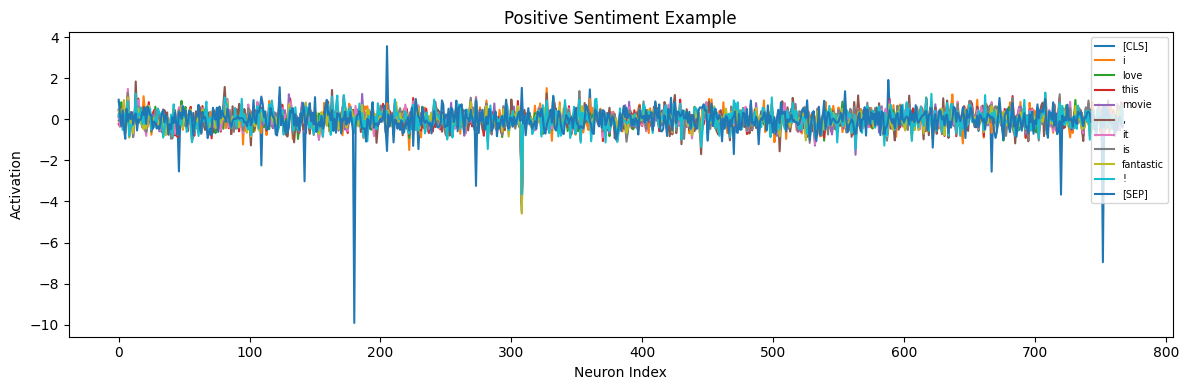

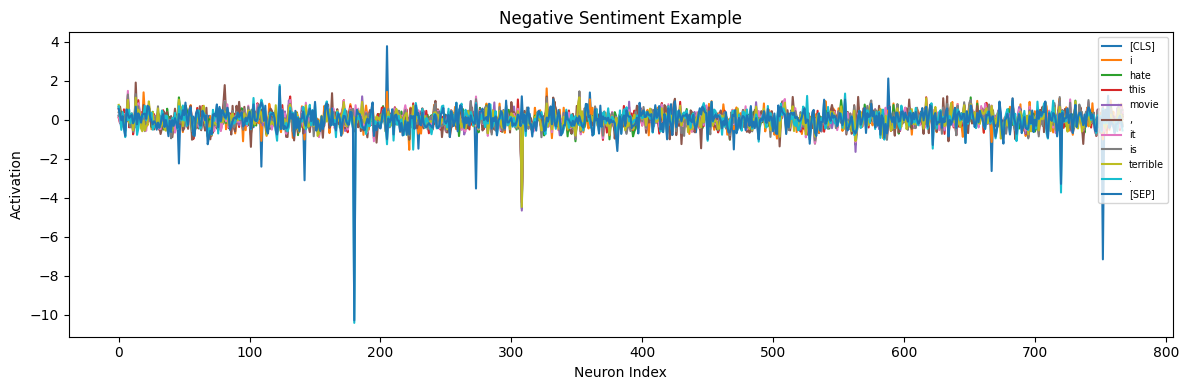

In [5]:
import matplotlib.pyplot as plt

def plot_token_activations(tokens, hidden, title, filename):
    plt.figure(figsize=(12, 4))
    for i, token in enumerate(tokens):
        plt.plot(hidden[i].numpy(), label=token)
    plt.title(title)
    plt.xlabel("Neuron Index")
    plt.ylabel("Activation")
    plt.legend(loc="upper right", fontsize="x-small")
    plt.tight_layout()
    #plt.savefig(filename)
    plt.show()
    plt.close()

# Positive example
tokens_pos, hidden_pos = get_hidden_states("I love this movie, it is fantastic!")
plot_token_activations(tokens_pos, hidden_pos, "Positive Sentiment Example", "positive_sentiment.png")

# Negative example
tokens_neg, hidden_neg = get_hidden_states("I hate this movie, it is terrible.")
plot_token_activations(tokens_neg, hidden_neg, "Negative Sentiment Example", "negative_sentiment.png")

After running the code python app.py, check your folder — you’ll see two image files: positive_sentiment.png and negative_sentiment.png. They’ll look like line graphs showing activations for each token.

- Figure 1: Activations for a positive review. Words like “love” and “fantastic” activate distinctive neuron patterns.
- Figure 2: Activations for a negative review. Words like “hate” and “terrible” trigger different neuron curves.

### Step 4: Compare Two Sentences
This step compares average neuron patterns between two sentences.

Now in the same app.py, add this function below the step 3 code.

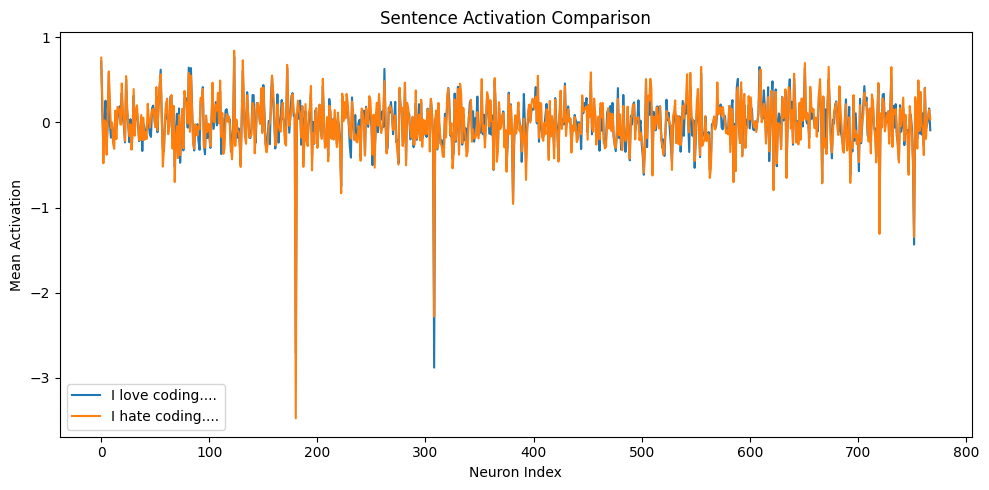

In [ ]:
def compare_sentences(s1, s2, filename):
    tokens1, hidden1 = get_hidden_states(s1)
    tokens2, hidden2 = get_hidden_states(s2)

    plt.figure(figsize=(10,5))
    plt.plot(hidden1.mean(dim=0).numpy(), label=s1[:30]+"...")
    plt.plot(hidden2.mean(dim=0).numpy(), label=s2[:30]+"...")
    plt.title("Sentence Activation Comparison")
    plt.xlabel("Neuron Index")
    plt.ylabel("Mean Activation")
    plt.legend()
    plt.tight_layout()
    #plt.savefig(filename)
    plt.show()
    plt.close()

compare_sentences("I love coding.", "I hate coding.", "sentence_comparison.png")

After running the code python app.py, You’ll now get sentence_comparison.png, showing two curves — one for the happy sentence, one for the negative.

Figure 3: Comparing “I love coding” vs “I hate coding”. Even averaged across tokens, neuron profiles differ significantly.

### Step 5: Visualize Analogies with PCA
We can check if embeddings encode semantic analogies like man → woman :: king → queen.

This step projects word embeddings like man, woman, king, queen into 2D space so you can see relationships.

Now in the same app.py, add this function below the step 4 code.

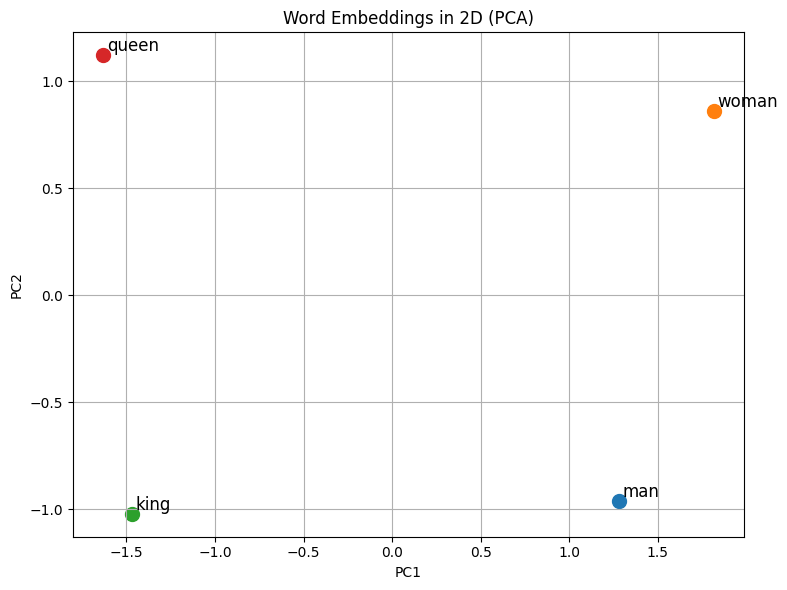

In [ ]:
from sklearn.decomposition import PCA

def get_sentence_embedding(text):
    inputs = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    hidden = outputs.last_hidden_state.mean(dim=1).squeeze()
    return hidden

def plot_embeddings(words, embeddings, filename):
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(torch.stack(embeddings).numpy())

    plt.figure(figsize=(8, 6))
    for i, word in enumerate(words):
        x, y = reduced[i]
        plt.scatter(x, y, marker="o", s=100)
        plt.text(x+0.02, y+0.02, word, fontsize=12)
    plt.title("Word Embeddings in 2D (PCA)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.tight_layout()
    #plt.savefig(filename)
    plt.show()
    plt.close()

words = ["man", "woman", "king", "queen"]
embeddings = [get_sentence_embedding(w) for w in words]
plot_embeddings(words, embeddings, "word_analogies.png")

After running the code python app.py , you’ll have word_analogies.png showing the famous man→woman and king→queen relationship as almost parallel lines.

Figure 4: PCA visualization of word embeddings. Man–woman and king–queen form parallel relationships, reflecting analogy structure.

## Conclusion
You’ve built a local toolkit to:

- Extract hidden activations from an LLM

- Visualize neuron activity for positive vs. negative sentiment

- Explore semantic analogies like “king → queen”

- Inspect potential biases in role associations

This helps demystify LLMs — showing they’re massive matrices of numbers encoding meaning, not magic.

Small models like DistilBERT run on any laptop. Larger models like LLaMA 2 can scale exploration further.